In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 38.1 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 36.7 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
#import cv2



import os
import timm
import random

from mtcnn import MTCNN

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle
import time
import torch.optim as optim


device = torch.device('cuda')

# torch model 저장
def model_save(model, score,  path):
    os.makedirs('model', exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'score': score
    }, path)

In [ ]:
#이미지 파일 불러오기

train_imgs = np.load('/content/drive/MyDrive/D&A_conference/seoyoon_train_imgs.npy',allow_pickle=True)
test_imgs = np.load('/content/drive/MyDrive/D&A_conference/seoyoon_test_imgs.npy',allow_pickle=True)

라벨링은 그냥 파일명에서 파싱

> train, test 각각 img파일 불러와서 합치기



In [ ]:
train_jpg = sorted(
sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/spring/*'))[20:]+
sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/summer/*'))[20:]+
sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/winter/*')[20:]+
sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/fall/*'))[20:])+
sorted(glob('/content/drive/MyDrive/D&A_conference/res/train/*/*')))
print(len(train_jpg))

764


In [ ]:
# test_jpg = (sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/fall/*'))[:20] + 
# sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/spring/*'))[:20]+
# sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/summer/*'))[:20]+
# sorted(glob('/content/drive/MyDrive/D&A_conference/dataset/winter/*'))[:20]+
# sorted(glob('/content/drive/MyDrive/D&A_conference/res/test/*/*'))
# )
# # sorted(glob('/content/drive/MyDrive/D&A_conference/res/test/*/*')))
# print(len(test_jpg))

120


In [ ]:
# Train 라벨만 추출
train_labels = []
for i in train_jpg:
    train_labels.append(i.split('/')[-2])

# Test 라벨만 추출
test_labels = []
for i in test_jpg:
    test_labels.append(i.split('/')[-2])

In [ ]:
import numpy as np
print(len(train_labels))
print(len(test_labels))
print(np.unique(train_labels))
print(np.unique(test_labels))

764
40
['fall' 'spring' 'summer' 'winter']
['nfall' 'nspring' 'nsummer' 'nwinter']


In [ ]:
print(np.unique(train_labels))

['fall' 'spring' 'summer' 'winter']


In [ ]:
# Label encoding
for i in range(len(train_labels)):
  if train_labels[i] == 'spring':
    train_labels[i] = 0
  elif train_labels[i] == 'summer':
    train_labels[i] = 1
  elif train_labels[i] == 'fall':
    train_labels[i] = 2
  else:
    train_labels[i] = 3

In [ ]:
for i in range(len(test_labels)):
  if test_labels[i] == 'nspring' or test_labels[i] == 'spring':
    test_labels[i] = 0
  elif test_labels[i] == 'nsummer' or test_labels[i] == 'summer':
    test_labels[i] = 1
  elif test_labels[i] == 'nfall' or test_labels[i] == 'fall':
    test_labels[i] = 2
  else:
    test_labels[i] = 3

In [ ]:
print(train_labels.count(0))
print(train_labels.count(1))
print(train_labels.count(2))
print(train_labels.count(3))

217
215
168
164


In [ ]:
print(test_labels.count(0))
print(test_labels.count(1))
print(test_labels.count(2))
print(test_labels.count(3))

30
30
30
30


In [ ]:
train_csv = pd.concat([pd.Series(train_jpg),pd.Series(train_labels)],axis = 1)
test_csv = pd.concat([pd.Series(test_jpg),pd.Series(test_labels)],axis = 1)

train_csv.to_csv('train_all_label.csv',index = False)
test_csv.to_csv('test_all_label.csv',index = False)

In [ ]:
# Test Image는 서윤이 데이터셋으로만 진행.
test_jpg = sorted(
    sorted(glob('/content/drive/MyDrive/D&A_conference/res/test/*/*'))
)

test_labels = []
for i in test_jpg:
    test_labels.append(i.split('/')[-2])

print(np.unique(test_labels))

for i in range(len(test_labels)):
  if test_labels[i] == 'nspring' or test_labels[i] == 'spring':
    test_labels[i] = 0
  elif test_labels[i] == 'nsummer' or test_labels[i] == 'summer':
    test_labels[i] = 1
  elif test_labels[i] == 'nfall' or test_labels[i] == 'fall':
    test_labels[i] = 2
  else:
    test_labels[i] = 3

print(test_labels)

['nfall' 'nspring' 'nsummer' 'nwinter']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
import cv2

In [ ]:
def im_trim (img): #함수로 만든다
    x = bounding_box[0][0]; y = bounding_box[0][1]; #자르고 싶은 지점의 x좌표와 y좌표 지정
    w = bounding_box[0][2]; h = bounding_box[0][3]; #x로부터 width, y로부터 height를 지정
    img_trim = img[y:y+h, x:x+w] #trim한 결과를 img_trim에 담는다
    return img_trim #필요에 따라 결과물을 리턴

In [ ]:
def img_face_detect(path):
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    detections = detector.detect_faces(img)
    bounding_box = list(detections[0].values())
    
    def im_trim (img): #함수로 만든다
        x = bounding_box[0][0]; y = bounding_box[0][1]; #자르고 싶은 지점의 x좌표와 y좌표 지정
        w = bounding_box[0][2]; h = bounding_box[0][3]; #x로부터 width, y로부터 height를 지정
        img_trim = img[y:y+h, x:x+w] #trim한 결과를 img_trim에 담는다
        return img_trim #필요에 따라 결과물을 리턴

    trim_image = im_trim(img)
    
    #trim_image = cv2.resize(trim_image, (50, 50),interpolation = cv2.INTER_AREA)
    
    r,g,b = cv2.split(trim_image)
    trim_image = cv2.merge([b,g,r])

    face_img_ycrcb = cv2.cvtColor(trim_image, cv2.COLOR_BGR2YCrCb)

    lower = np.array([0,133,77], dtype = np.uint8)
    upper = np.array([255,173,127], dtype = np.uint8)
    skin_msk = cv2.inRange(face_img_ycrcb, lower, upper) #OpenCV의 inRange함수는 
                                                         #특정 이미지 데이터의 상/하한선을 정해놓고 그 안에 들어오는 pixel들은 1로,
                                                         #나머지 pixel들은 0으로 만들겠다 라는 함수 입니다.
        
    skin = cv2.bitwise_and(trim_image, trim_image, mask = skin_msk)
    b,g,r = cv2.split(skin)
    skin = cv2.merge([r,g,b])
    return skin

In [ ]:
# train_imgs = [img_face_detect(m) for m in tqdm(train_jpg)]
test_imgs = [img_face_detect(n) for n in tqdm(test_jpg)]

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 165ms/step


  2%|▎         | 1/40 [00:15<10:07, 15.57s/it]

1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 161ms/step


  5%|▌         | 2/40 [00:17<04:55,  7.78s/it]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 3/40 [00:20<03:22,  5.48s/it]

1/1 [==============================] - 0s 152ms/step


 10%|█         | 4/40 [00:23<02:34,  4.29s/it]

1/1 [==============================] - 0s 166ms/step


 12%|█▎        | 5/40 [00:25<02:04,  3.56s/it]

1/1 [==============================] - 0s 111ms/step


 15%|█▌        | 6/40 [00:27<01:47,  3.16s/it]

1/1 [==============================] - 0s 153ms/step


 18%|█▊        | 7/40 [00:30<01:38,  2.98s/it]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 8/40 [00:32<01:31,  2.85s/it]

1/1 [==============================] - 0s 130ms/step


 22%|██▎       | 9/40 [00:35<01:26,  2.78s/it]

1/1 [==============================] - 0s 155ms/step


 25%|██▌       | 10/40 [00:38<01:21,  2.71s/it]

1/1 [==============================] - 0s 112ms/step


 28%|██▊       | 11/40 [00:40<01:18,  2.70s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 12/40 [00:43<01:15,  2.69s/it]

1/1 [==============================] - 0s 161ms/step


 32%|███▎      | 13/40 [00:46<01:14,  2.74s/it]

1/1 [==============================] - 0s 118ms/step


 35%|███▌      | 14/40 [00:49<01:13,  2.84s/it]

1/1 [==============================] - 0s 110ms/step


 38%|███▊      | 15/40 [00:52<01:11,  2.86s/it]

1/1 [==============================] - 0s 111ms/step


 40%|████      | 16/40 [00:55<01:07,  2.82s/it]

1/1 [==============================] - 0s 109ms/step


 42%|████▎     | 17/40 [00:58<01:07,  2.95s/it]

1/1 [==============================] - 0s 181ms/step


 45%|████▌     | 18/40 [01:01<01:07,  3.08s/it]

1/1 [==============================] - 0s 128ms/step


 48%|████▊     | 19/40 [01:04<01:05,  3.10s/it]

1/1 [==============================] - 0s 114ms/step


 50%|█████     | 20/40 [01:07<01:00,  3.01s/it]

1/1 [==============================] - 0s 114ms/step


 52%|█████▎    | 21/40 [01:09<00:53,  2.81s/it]

1/1 [==============================] - 0s 144ms/step


 55%|█████▌    | 22/40 [01:12<00:50,  2.79s/it]

1/1 [==============================] - 0s 109ms/step


 57%|█████▊    | 23/40 [01:15<00:45,  2.70s/it]

1/1 [==============================] - 0s 112ms/step


 60%|██████    | 24/40 [01:17<00:41,  2.57s/it]

1/1 [==============================] - 0s 109ms/step


 62%|██████▎   | 25/40 [01:21<00:44,  2.97s/it]

1/1 [==============================] - 0s 117ms/step


 65%|██████▌   | 26/40 [01:23<00:39,  2.83s/it]

1/1 [==============================] - 0s 164ms/step


 68%|██████▊   | 27/40 [01:26<00:35,  2.71s/it]

1/1 [==============================] - 0s 114ms/step


 70%|███████   | 28/40 [01:28<00:29,  2.45s/it]

1/1 [==============================] - 0s 132ms/step


 72%|███████▎  | 29/40 [01:30<00:26,  2.45s/it]

1/1 [==============================] - 0s 119ms/step


 75%|███████▌  | 30/40 [01:33<00:25,  2.55s/it]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 31/40 [01:35<00:22,  2.51s/it]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 32/40 [01:38<00:19,  2.43s/it]

1/1 [==============================] - 0s 115ms/step


 82%|████████▎ | 33/40 [01:40<00:18,  2.58s/it]

1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 34/40 [01:43<00:15,  2.56s/it]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 35/40 [01:45<00:12,  2.49s/it]

1/1 [==============================] - 0s 114ms/step


 90%|█████████ | 36/40 [01:48<00:09,  2.46s/it]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▎| 37/40 [01:50<00:07,  2.42s/it]

1/1 [==============================] - 0s 115ms/step


 95%|█████████▌| 38/40 [01:52<00:04,  2.41s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 39/40 [01:55<00:02,  2.42s/it]

1/1 [==============================] - 0s 130ms/step


100%|██████████| 40/40 [01:57<00:00,  2.94s/it]


(-0.5, 52.5, 78.5, -0.5)

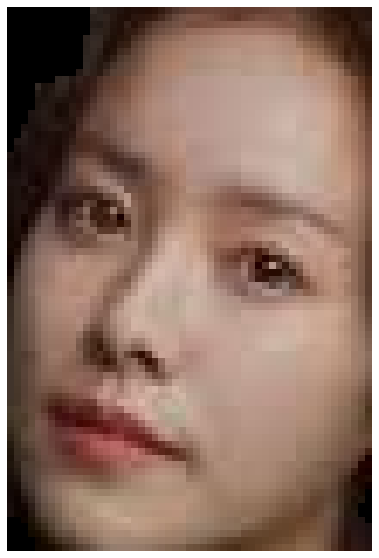

In [ ]:
import matplotlib.pylab as plt

#피부 이미지 확인
plt.figure(figsize = (10,10))
plt.imshow(train_imgs[160])
plt.axis('off')

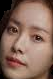

In [ ]:
from PIL import Image

Image.fromarray(train_imgs[160])

### 시도해보려는 상황... -> 

    1) 256으로 resize하고 보간한다음에 평활화나 normalize 진행

    2) 그냥 바로 평활화나 normalize 진행

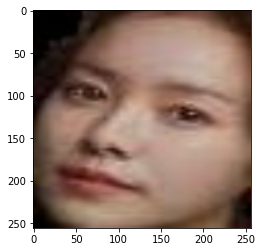

In [ ]:
## 픽셀이 너무 깨지는 것들이 있어서 해상도를 올려보자..
# !pip install opencv-python==4.3.0.38
# !pip install opencv-contrib-python==4.3.0.38
import cv2

im = Image.fromarray(train_imgs[160])
im.save('sample.jpg')

img = cv2.imread('sample.jpg') 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

resized = cv2.resize(img,(256,256),interpolation = cv2.INTER_LINEAR)
plt.imshow(resized)

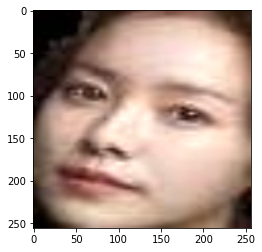

In [ ]:
# 히스토그램 스트레칭

src = cv2.imread('sample.jpg', cv2.IMREAD_COLOR)
src = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
src_ycrcb = cv2.cvtColor(src, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(src_ycrcb)
dst_y = cv2.normalize(y,None,0,255,cv2.NORM_MINMAX)
dst_ycrcb = cv2.merge([dst_y, cr, cb])
dst_normal = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2BGR)
plt.imshow(dst_normal)

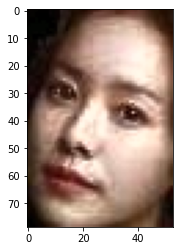

In [ ]:
# 히스토그램 평활화
src = cv2.imread('sample.jpg', cv2.IMREAD_COLOR)

src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
src_ycrcb = cv2.cvtColor(src, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(src_ycrcb)
dst_y = cv2.equalizeHist(y)
dst_ycrcb = cv2.merge([dst_y, cr, cb])
dst = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2RGB) # RESIZE를 안하면 이부분을 RGB로 바꿈.
plt.imshow(dst)

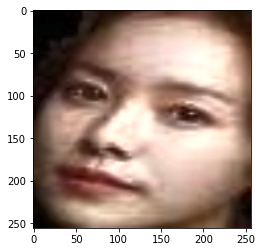

In [ ]:
# 히스토그램 평활화
# src = cv2.imread('sample.jpg', cv2.IMREAD_COLOR)

src = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
src_ycrcb = cv2.cvtColor(src, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(src_ycrcb)
dst_y = cv2.equalizeHist(y)
dst_ycrcb = cv2.merge([dst_y, cr, cb])
dst = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2BGR) # resize를 해주면 이부분을 BGR로 바꿔주어야함
plt.imshow(dst)

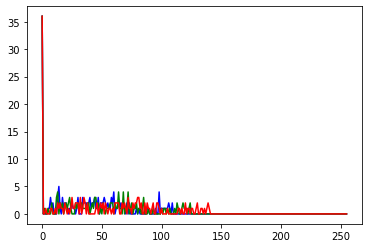

In [ ]:
# 평활화 하기전
from ctypes import RTLD_GLOBAL
colors = ['b','g','r']
for (rgb, c) in zip(train_imgs[160], colors):
    hist = cv2.calcHist([rgb], [0], None, [256], [0, 256])
    plt.plot(hist, color=c)

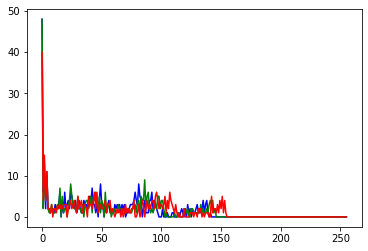

In [ ]:
# normalize(스트레칭)하고 난 후 

from ctypes import RTLD_GLOBAL
colors = ['b','g','r']
for (rgb, c) in zip(dst_normal, colors):
    hist = cv2.calcHist([rgb], [0], None, [256], [0, 256])
    plt.plot(hist, color=c)

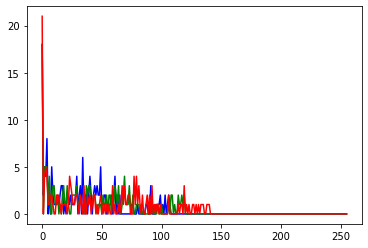

In [ ]:
# 평활화 한 후
from ctypes import RTLD_GLOBAL
colors = ['b','g','r']
for (rgb, c) in zip(dst, colors):
    hist = cv2.calcHist([rgb], [0], None, [256], [0, 256])
    plt.plot(hist, color=c)

In [ ]:
# 평활화 하기 위한 함수 생성

def hist_equal(image_one): # 이미지 하나하나
  im = Image.fromarray(image_one)
  im.save('sample.jpg')

  # 이미지 저장 및 resize와 interpolation
  img = cv2.imread('sample.jpg') 
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  resized = cv2.resize(img,(256,256),interpolation = cv2.INTER_LINEAR)

  # 평활화 과정

  src = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
  src_ycrcb = cv2.cvtColor(src, cv2.COLOR_RGB2YCrCb)
  y, cr, cb = cv2.split(src_ycrcb)
  dst_y = cv2.equalizeHist(y)
  dst_ycrcb = cv2.merge([dst_y, cr, cb])
  dst_equal = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2BGR) # resize를 해주면 이부분을 BGR로 바꿔주어야함
  return dst_equal
  

In [ ]:
# 단순 normalize하는 함수 생성
def hist_normal(image_one): # 이미지 하나하나
  im = Image.fromarray(image_one)
  im.save('sample.jpg')

  # 이미지 저장 및 resize와 interpolation
  img = cv2.imread('sample.jpg') 
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  resized = cv2.resize(img,(256,256),interpolation = cv2.INTER_LINEAR)

  # 평활화 과정

  src = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)
  src_ycrcb = cv2.cvtColor(src, cv2.COLOR_RGB2YCrCb)
  y, cr, cb = cv2.split(src_ycrcb)
  dst_y = cv2.normalize(y,None,0,255,cv2.NORM_MINMAX)
  dst_ycrcb = cv2.merge([dst_y, cr, cb])
  dst_equal = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2BGR) # resize를 해주면 이부분을 BGR로 바꿔주어야함
  return dst_normal
  

In [ ]:
normal_train_imgs = []
normal_test_imgs = []

from tqdm.auto import tqdm
for img in tqdm(train_imgs):
  normal_train_imgs.append(hist_normal(img))

for img in tqdm(test_imgs):
  normal_test_imgs.append(hist_normal(img))

  0%|          | 0/764 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
equal_train_imgs = []
equal_test_imgs = []

from tqdm.auto import tqdm
for img in tqdm(train_imgs):
  equal_train_imgs.append(hist_equal(img))

for img in tqdm(test_imgs):
  equal_test_imgs.append(hist_equal(img))

  0%|          | 0/764 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

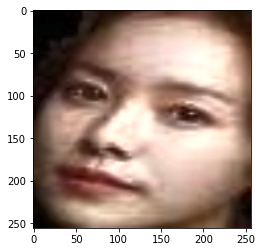

In [ ]:
plt.imshow(equal_train_imgs[160])

In [ ]:
from PIL import Image

equal_test_imgs = []

for img in tqdm(test_imgs):
  equal_test_imgs.append(hist_equal(img))

100%|██████████| 40/40 [00:00<00:00, 116.81it/s]


### test 100장으로만 진행

In [ ]:
np.save('test_seoyoon_imgs',np.array(test_imgs))
np.save('test_equal_seoyoon_imgs',np.array(equal_test_imgs))

In [ ]:
# 원본 이미지를 npy파일로 이미지 저장

np.save('train_all_imgs', np.array(train_imgs))
np.save('test_all_imgs', np.array(test_imgs))

In [ ]:
# normalize한 이미지를 npy파일로 이미지 저장

np.save('train_normal_imgs', np.array(normal_train_imgs))
np.save('test_normal_imgs', np.array(normal_test_imgs))

In [ ]:
# equal 한 이미지를 npy 파일로 저장.

np.save('train_equal_imgs', np.array(equal_train_imgs))
np.save('test_equal_imgs', np.array(equal_test_imgs))

In [ ]:
#이미지 파일 불러오기

train_imgs = np.load('train_all_imgs.npy',allow_pickle=True)
test_imgs = np.load('test_all_imgs.npy',allow_pickle=True)

In [ ]:
# 이거로 실험 진행.
train_imgs = np.load('/content/drive/MyDrive/D&A_conference/합친_데이터/train_equal_imgs.npy',allow_pickle=True)
test_imgs = np.load('/content/drive/MyDrive/D&A_conference/합친_데이터/test_equal_seoyoon_imgs.npy',allow_pickle=True)

- 

In [ ]:
#데이터 셋 구성

class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode == 'train':
          train_transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Resize((128, 128)),
                transforms.RandomAffine((-45, 45)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ])
          img = train_transform(img)
        if self.mode == 'test':
          test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((128, 128)),
                transforms.RandomAffine((-45, 45)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ])
          img = test_transform(img)

        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self,mode = 'train'):
        super(Network, self).__init__()
        self.mode = mode
        if self.mode == 'train':
          self.model = timm.create_model('efficient_b0', pretrained=True, num_classes=4, drop_path_rate = 0.35)
        if self.mode == 'test':
          self.model = timm.create_model('efficient_b0', pretrained=True, num_classes=4, drop_path_rate = 0.35)
        
    def forward(self, x):
        x = self.model(x)
        return x

# 모델링

In [ ]:
# KFold
folds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(train_imgs):
    folds.append((train_idx, valid_idx))
fold=0
train_idx, valid_idx = folds[fold]


batch_size = 16
epochs = 20


# Train
train_dataset = Custom_dataset(np.array(train_imgs)[train_idx], np.array(train_labels)[train_idx], mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)

# Validation 
valid_dataset = Custom_dataset(np.array(train_imgs)[valid_idx], np.array(train_labels)[valid_idx], mode='valid')
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, pin_memory=True)

In [ ]:
# 평가지표

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [ ]:
import gc

cv = StratifiedKFold(n_splits = 5, random_state = 42,shuffle=True)
batch_size = 24
epochs = 40
pred_ensemble = []


for idx, (train_idx, val_idx) in enumerate(cv.split(train_imgs, np.array(train_labels))):
  print("----------fold_{} start!----------".format(idx))
  t_imgs, val_imgs = train_imgs[train_idx],  train_imgs[val_idx]
  t_labels, val_labels = np.array(train_labels)[train_idx], np.array(train_labels)[val_idx]

  # Train
  train_dataset = Custom_dataset(np.array(t_imgs), np.array(t_labels), mode='train')
  train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

  # Val
  val_dataset = Custom_dataset(np.array(val_imgs), np.array(val_labels), mode='test')
  val_loader = DataLoader(val_dataset, shuffle= False, batch_size=batch_size)

  gc.collect()
  torch.cuda.empty_cache()
  best=0

  model = Network().to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 2e-2)
  criterion = nn.CrossEntropyLoss()
  scaler = torch.cuda.amp.GradScaler()  

  best_f1 = 0
  early_stopping = 0
  for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    train_f1 = score_function(train_y, train_pred)
    state_dict= model.state_dict()
    model.eval()
    with torch.no_grad():
      val_loss = 0 
      val_pred = []
      val_y = []
      

      for batch in (val_loader):
        x_val = torch.tensor(batch[0], dtype = torch.float32, device = device)
        y_val = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred_val = model(x_val)
        loss_val = criterion(pred_val, y_val)

        val_loss += loss_val.item()/len(val_loader)
        val_pred += pred_val.argmax(1).detach().cpu().numpy().tolist()
        val_y += y_val.detach().cpu().numpy().tolist()
      val_f1 = score_function(val_y, val_pred)

      if val_f1 > best_f1:
        best_epoch = epoch
        best_loss = val_loss
        best_f1 = val_f1
        early_stopping = 0

        torch.save({'epoch':epoch,
                    'state_dict':state_dict,
                    'optimizer': optimizer.state_dict(),
                    'scaler': scaler.state_dict(),
             }, 'best_model_{}.pth'.format(idx))
        print('-----------------SAVE:{} epoch----------------'.format(best_epoch+1))
      else:
          early_stopping += 1

            # Early Stopping
      if early_stopping == 20:
        TIME = time.time() - start
        print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
        print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
        print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')
        break

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    print(f'Val    loss : {val_loss:.5f}    f1 : {val_f1:.5f}')

----------fold_0 start!----------
-----------------SAVE:1 epoch----------------
epoch : 1/40    time : 4s/153s
TRAIN    loss : 1.38454    f1 : 0.18040
Val    loss : 1.38811    f1 : 0.23081
epoch : 2/40    time : 3s/124s
TRAIN    loss : 1.37872    f1 : 0.14900
Val    loss : 1.37988    f1 : 0.21751
epoch : 3/40    time : 3s/121s
TRAIN    loss : 1.37560    f1 : 0.20562
Val    loss : 1.37709    f1 : 0.20851
epoch : 4/40    time : 3s/118s
TRAIN    loss : 1.35194    f1 : 0.22621
Val    loss : 1.36733    f1 : 0.18893
epoch : 5/40    time : 3s/113s
TRAIN    loss : 1.33402    f1 : 0.24043
Val    loss : 1.36147    f1 : 0.22726
-----------------SAVE:6 epoch----------------
epoch : 6/40    time : 4s/140s
TRAIN    loss : 1.31964    f1 : 0.27480
Val    loss : 1.33022    f1 : 0.31872
-----------------SAVE:7 epoch----------------
epoch : 7/40    time : 4s/128s
TRAIN    loss : 1.32073    f1 : 0.34489
Val    loss : 1.36342    f1 : 0.33840
epoch : 8/40    time : 3s/105s
TRAIN    loss : 1.29102    f1 : 0.

In [ ]:
pred_ensemble = []
# batch_size = 7

for i in range(5):
  model_test = Network(mode = 'test').to(device)
  model_test.load_state_dict(torch.load(('best_model_{}.pth'.format(i)))['state_dict'])
  model_test.eval()
  pred_prob = []
  with torch.no_grad():
      for batch in (test_loader):
          x = torch.tensor(batch[0], dtype = torch.float32, device = device)
          with torch.cuda.amp.autocast():
              pred = model_test(x)
              pred_prob.extend(pred.detach().cpu().numpy())
      pred_ensemble.append(pred_prob)

In [ ]:
len(test_imgs)

40

In [ ]:
pred_ensemble

In [ ]:
score_function(test_labels, np.array(pred_prob).argmax(1).tolist())

0.4527777777777778

In [ ]:
 print(np.array(pred_prob).argmax(1).tolist())
 print(test_labels)

[3, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 3, 0, 1, 2, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


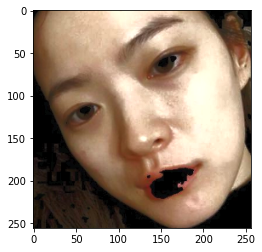

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_imgs[0])

In [ ]:
print(score_function(test_labels, np.array(pred_ensemble[0]).argmax(1).tolist()))
print(score_function(test_labels, np.array(pred_ensemble[1]).argmax(1).tolist()))
print(score_function(test_labels, np.array(pred_ensemble[2]).argmax(1).tolist()))
print(score_function(test_labels, np.array(pred_ensemble[3]).argmax(1).tolist()))
print(score_function(test_labels, np.array(pred_ensemble[4]).argmax(1).tolist()))

0.32277933895356614
0.2546474358974359
0.31865508633243184
0.3412946428571429
0.4772859111805089


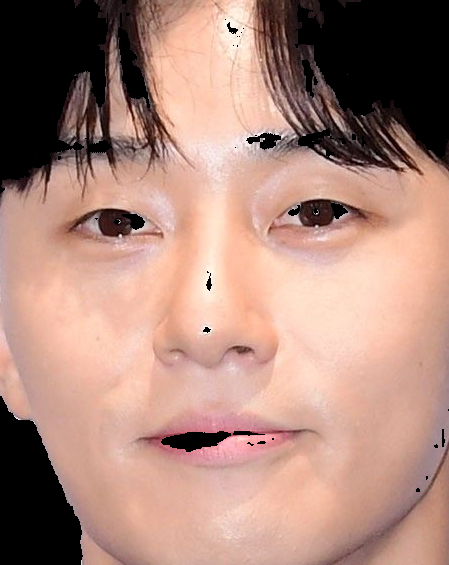

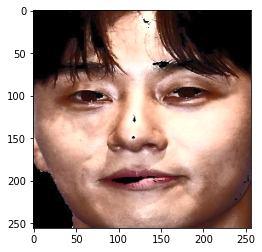

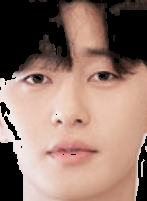

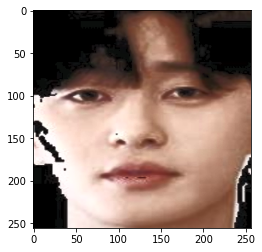

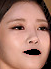

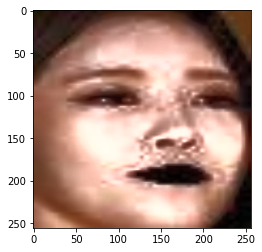

In [ ]:
from google.colab.patches import cv2_imshow
original18 = cv2.cvtColor(train_imgs[18], cv2.COLOR_BGR2RGB)
cv2_imshow(original18)
plt.imshow(equal_train_imgs[18])
plt.show()

original11 = cv2.cvtColor(train_imgs[11], cv2.COLOR_BGR2RGB)
cv2_imshow(original11)
plt.imshow(equal_train_imgs[11])
plt.show()

original57 = cv2.cvtColor(train_imgs[57], cv2.COLOR_BGR2RGB)
cv2_imshow(original57)
plt.imshow(equal_train_imgs[57])
plt.show()